# Predictive Modelling for Lung Cancer Mortality

## Importing Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from collections import Counter

2024-08-19 00:20:52.342143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Splitting the dataset, taking a random sample of 100,000 entries out of 325000

In [ ]:
import pandas as pd

# Load the dataset
file_path = 'Downloads/archive (19)/lung_cancer_mortality_data_large_v2.csv'
data = pd.read_csv(file_path)

# Check the number of rows in the dataset
print(f"Total number of instances in the dataset: {len(data)}")

# Randomly sample 100,000 instances
sampled_data = data.sample(n=100000, random_state=42)

# Save the sampled data to a new CSV file
output_file_path = 'Desktop/ML/lung_cancer_mortality_data_resampled.csv'
sampled_data.to_csv(output_file_path, index=False)

print(f"Sampled data saved to {output_file_path}")


## Dataset Overview

In [6]:
file_path = 'Downloads/archive (19)/lung_cancer_mortality_data_sampled.csv'
data = pd.read_csv(file_path)
data.head()
data.info()
data.describe()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           100000 non-null  int64  
 1   age                          100000 non-null  float64
 2   gender                       100000 non-null  object 
 3   country                      100000 non-null  object 
 4   diagnosis_date               100000 non-null  object 
 5   cancer_stage                 100000 non-null  object 
 6   beginning_of_treatment_date  100000 non-null  object 
 7   family_history               100000 non-null  object 
 8   smoking_status               100000 non-null  object 
 9   bmi                          100000 non-null  float64
 10  cholesterol_level            100000 non-null  int64  
 11  hypertension                 100000 non-null  int64  
 12  asthma                       100000 non-null  int64  
 13  

(100000, 18)

## Preprocessing Data: conversion and SMOTE

Distribution before SMOTE:  Counter({0: 62311, 1: 17689})


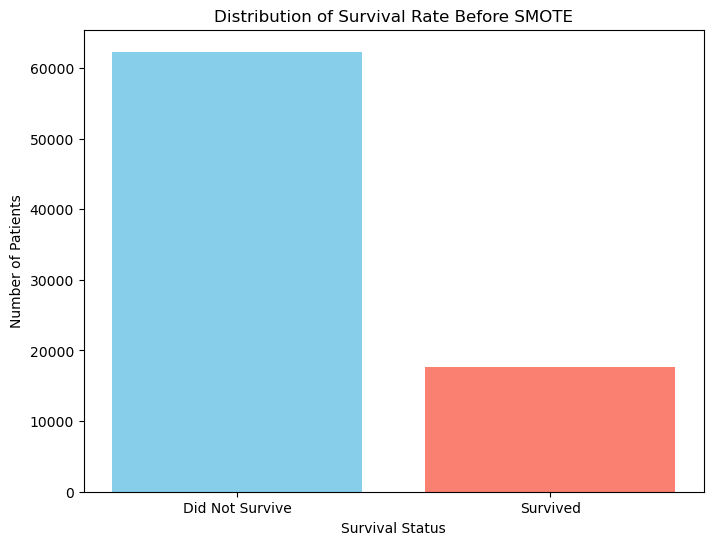

Distribution after SMOTE:  Counter({0: 62311, 1: 62311})


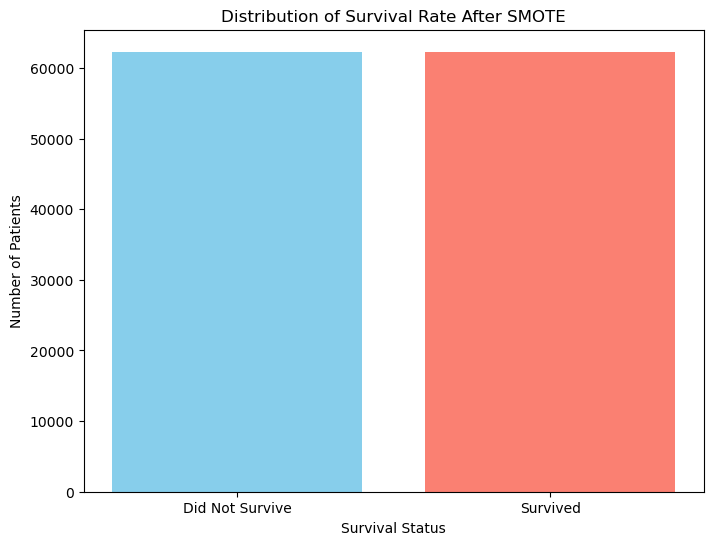

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

# Drop unnecessary columns and separate features and target
x = data.drop(["id", "diagnosis_date", "end_treatment_date", "survived", "beginning_of_treatment_date"], axis=1)

# Handle categorical data using OneHotEncoder if needed
categorical_columns = x.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse=False)
x_encoded = encoder.fit_transform(x[categorical_columns])

# Combine encoded categorical data with numerical data
x_numeric = x.select_dtypes(exclude=['object']).values
x = np.hstack((x_encoded, x_numeric))

# Scale the data
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

# Separate the target variable
y = data.loc[:, "survived"].values

# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

# Display distribution before SMOTE
print("Distribution before SMOTE: ", Counter(y_train))
plt.figure(figsize=(8, 6))
plt.bar(['Did Not Survive', 'Survived'], Counter(y_train).values(), color=['skyblue', 'salmon'])
plt.title('Distribution of Survival Rate Before SMOTE')
plt.xlabel('Survival Status')
plt.ylabel('Number of Patients')
plt.show()

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Display distribution after SMOTE
print("Distribution after SMOTE: ", Counter(y_train_resampled))
plt.figure(figsize=(8, 6))
plt.bar(['Did Not Survive', 'Survived'], Counter(y_train_resampled).values(), color=['skyblue', 'salmon'])
plt.title('Distribution of Survival Rate After SMOTE')
plt.xlabel('Survival Status')
plt.ylabel('Number of Patients')
plt.show()

## Checking distribution of continuous columns

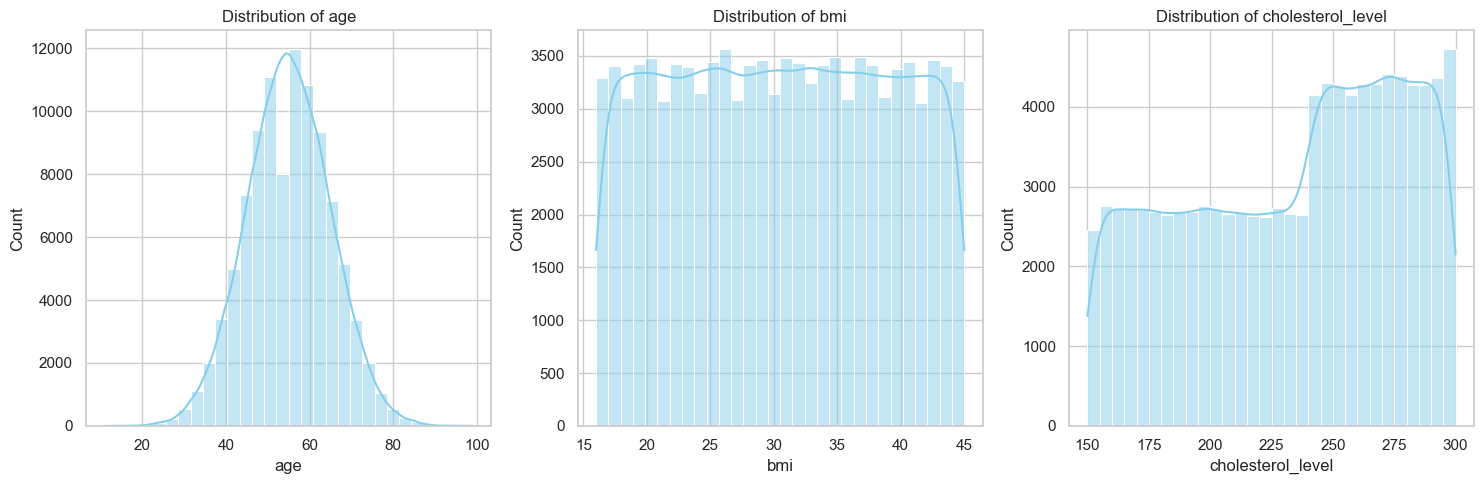

In [19]:
# Select the specific numerical columns you want to plot
columns_to_plot = ['age', 'bmi', 'cholesterol_level']

# Set the style for the plots
sns.set(style="whitegrid")

# Create histograms for the selected columns
plt.figure(figsize=(15, 5))
for i, col in enumerate(columns_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


## smoking status visualization

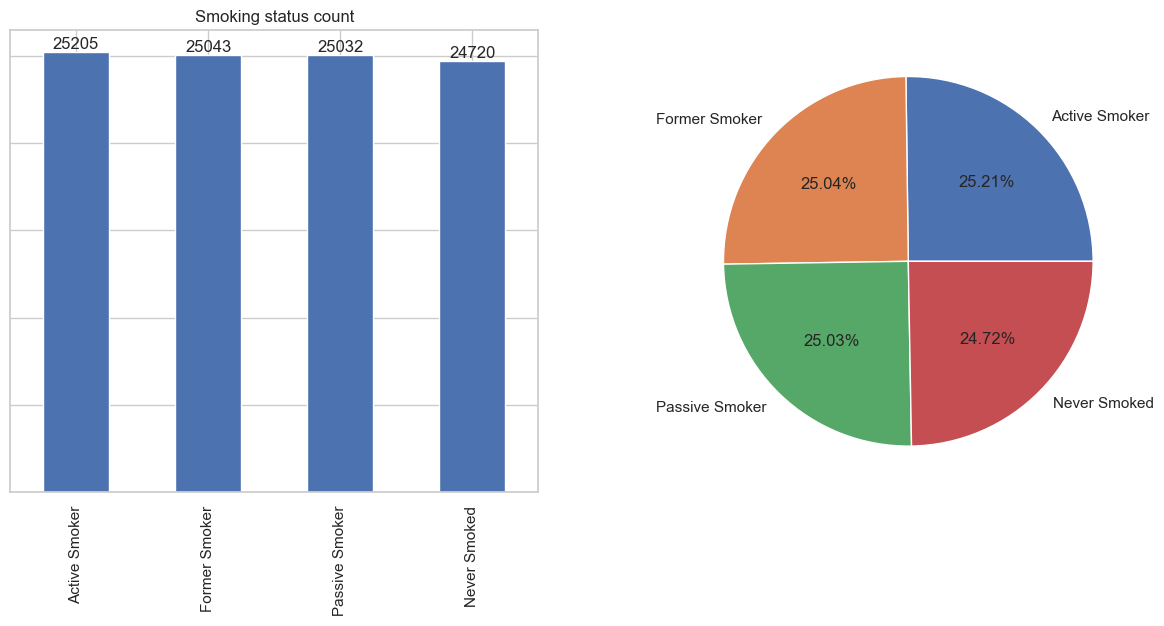

In [23]:
# Mapping of numeric codes to category types
smoking_status_mapping = {
    0: 'Never Smoked',
    1: 'Former Smoker',
    2: 'Passive Smoker',
    3: 'Active Smoker'
}

# Replace numerical values in "smoking_status" with the category types
data['smoking_status'] = data['smoking_status'].map(smoking_status_mapping)

# Plotting the bar and pie charts
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
data['smoking_status'].value_counts().plot(kind="bar", ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_yticklabels(())
axes[0].set_ylabel("")
axes[0].set_xlabel("")
axes[0].set_title("Smoking status count")
data['smoking_status'].value_counts().plot(kind="pie", ax=axes[1], autopct="%0.2f%%")
axes[1].set_ylabel("")
plt.show()


## effect of smoking on survival outcome

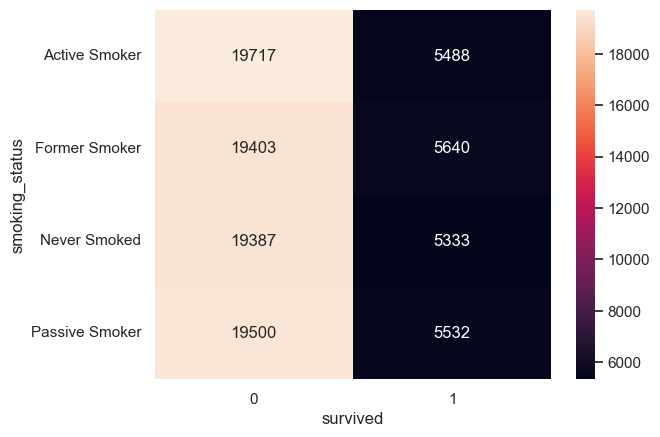

In [24]:
cross = pd.crosstab(data["smoking_status"], data["survived"])
sns.heatmap(cross, annot=True, fmt='d')
plt.show()

## effect of other diseases on patient outcome

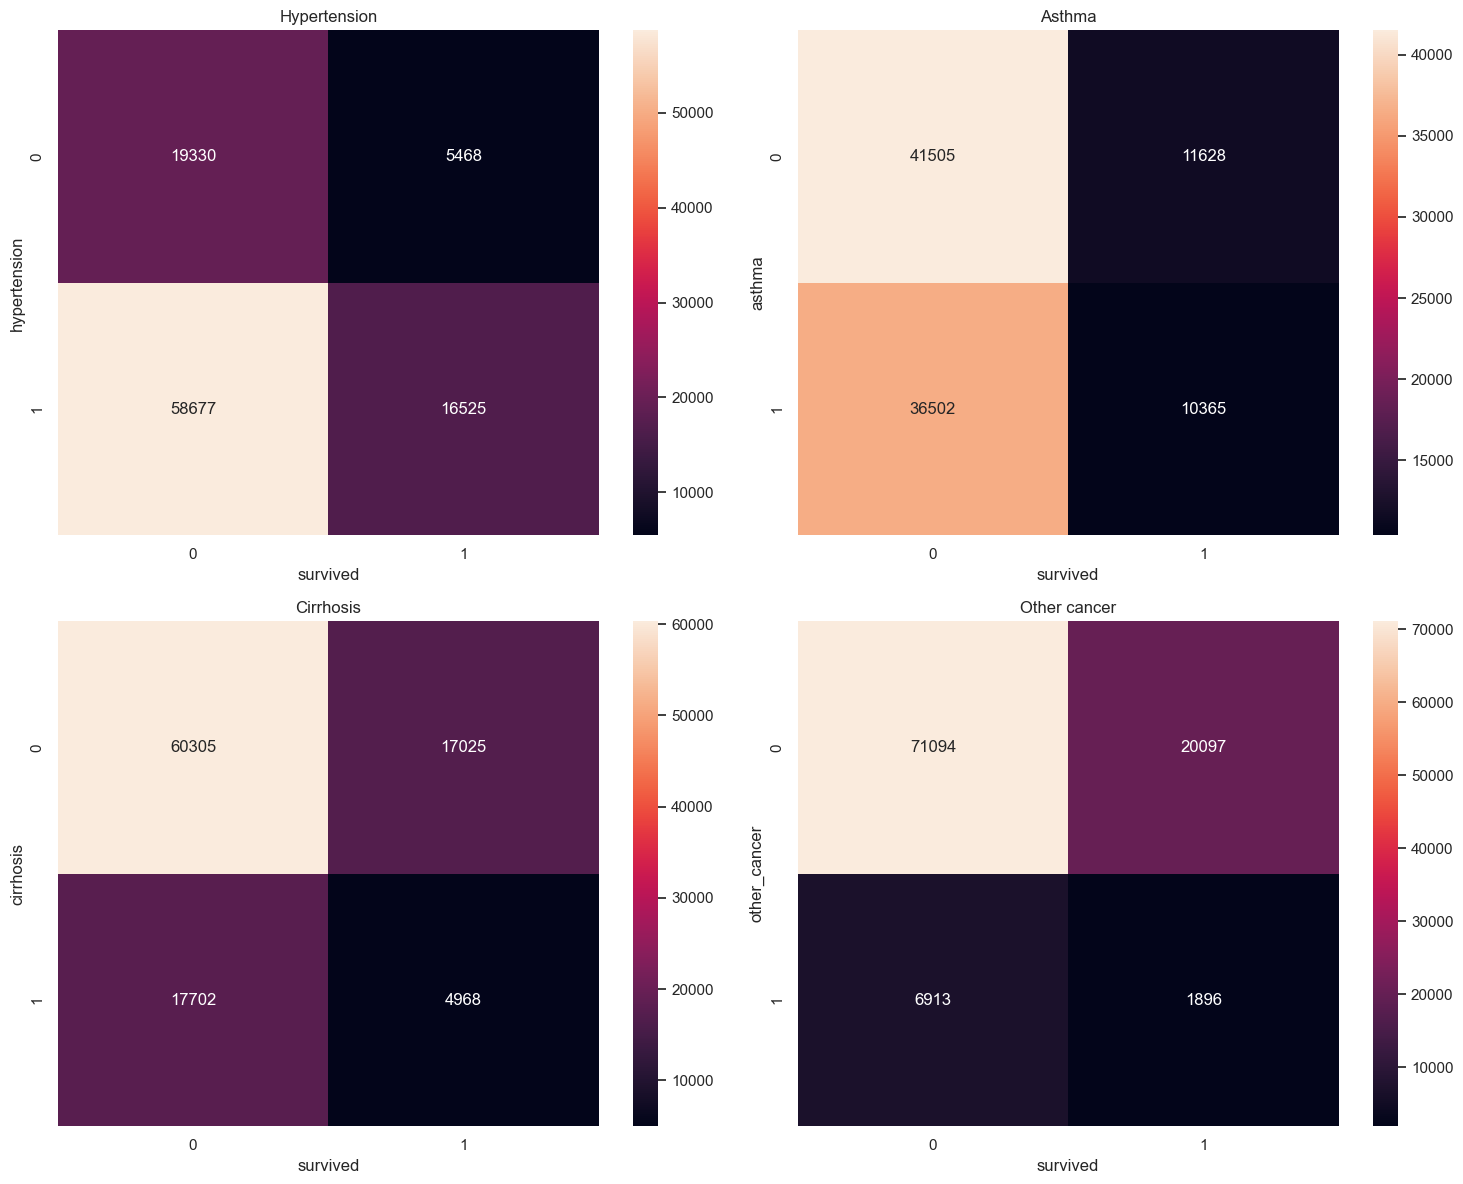

In [40]:
# List of diseases
diseases = ["hypertension", "asthma", "cirrhosis", "other_cancer"]

# Create a 2x2 grid for the heatmaps
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))  # Adjusted figure size for better spacing

for i, j in enumerate(diseases):
    row = i // 2  # Determine the row index (0 or 1)
    col = i % 2   # Determine the column index (0 or 1)
    cross = pd.crosstab(data[j], data["survived"])
    sns.heatmap(cross, annot=True, fmt='d', ax=axes[row, col])
    axes[row, col].set_title(j.replace('_', ' ').capitalize())

plt.tight_layout()
plt.show()

## Feature Importance using Random Forest Model

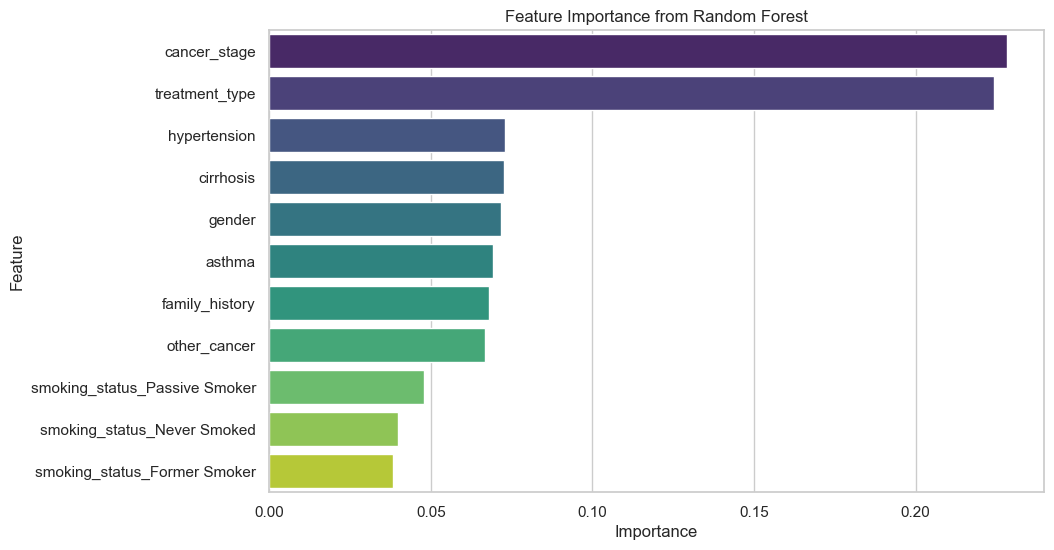

In [54]:
features = ['gender', 'cancer_stage', 'treatment_type', 'family_history', 'smoking_status', 
            'hypertension', 'asthma', 'cirrhosis', 'other_cancer']

X = data[features]
y = data['survived']

# Encode categorical variables if necessary
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Calculate feature importances
importances = rf.feature_importances_
feature_names = X_encoded.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Feature Engineering and LR coefficient model for evaluating effect on survival rate

Columns in the dataset: Index(['id', 'age', 'gender', 'country', 'diagnosis_date', 'cancer_stage',
       'beginning_of_treatment_date', 'family_history', 'smoking_status',
       'bmi', 'cholesterol_level', 'hypertension', 'asthma', 'cirrhosis',
       'other_cancer', 'treatment_type', 'end_treatment_date', 'survived'],
      dtype='object')
                             Feature  Coefficient
19            treatment_type_Surgery     0.000671
21               age_bmi_interaction     0.000654
14      smoking_status_Former Smoker     0.000635
10             cancer_stage_Stage II     0.000305
2                  cholesterol_level     0.000089
7                 treatment_duration    -0.000085
20  smoking_cancer_stage_interaction    -0.000314
4                             asthma    -0.000362
6                       other_cancer    -0.000364
11            cancer_stage_Stage III    -0.000406
8            time_to_treatment_start    -0.000523
18          treatment_type_Radiation    -0.000565
16   

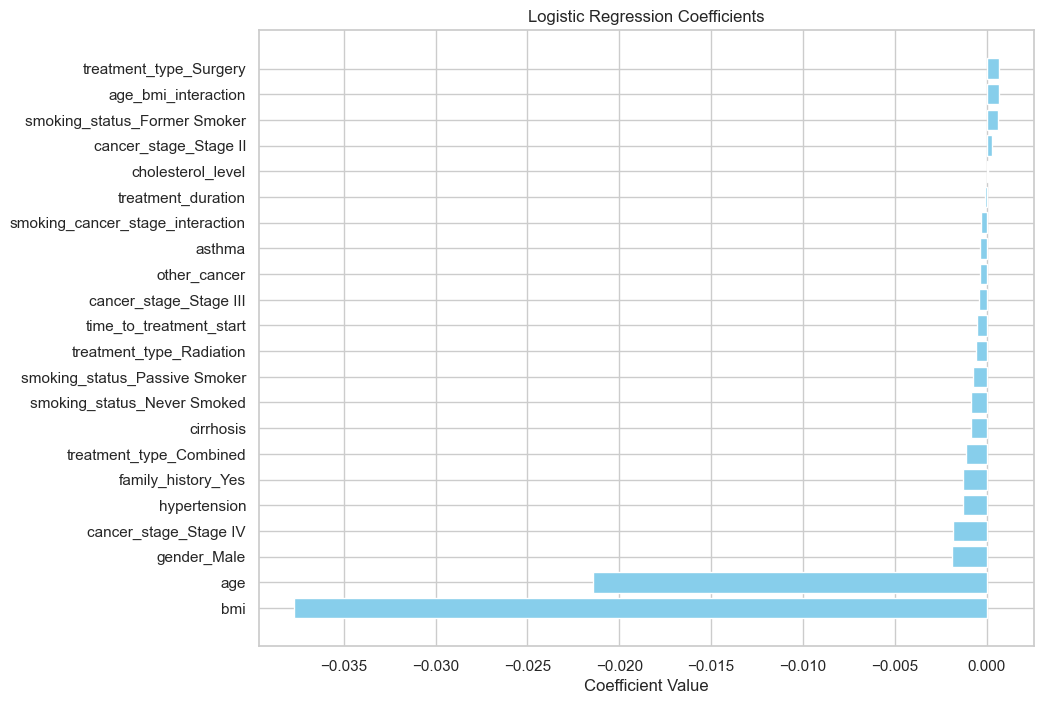

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'Desktop/ML/lung_cancer_mortality_data_sampled.csv'
data = pd.read_csv(file_path)

# Check the column names to ensure they are as expected
print("Columns in the dataset:", data.columns)

# Convert diagnosis_date and end_treatment_date to datetime
if 'diagnosis_date' in data.columns and 'end_treatment_date' in data.columns and 'beginning_of_treatment_date' in data.columns:
    data['diagnosis_date'] = pd.to_datetime(data['diagnosis_date'])
    data['end_treatment_date'] = pd.to_datetime(data['end_treatment_date'])
    data['beginning_of_treatment_date'] = pd.to_datetime(data['beginning_of_treatment_date'])

    # Feature: Duration of treatment
    data['treatment_duration'] = (data['end_treatment_date'] - data['beginning_of_treatment_date']).dt.days

    # Feature: Time from diagnosis to treatment start
    data['time_to_treatment_start'] = (data['beginning_of_treatment_date'] - data['diagnosis_date']).dt.days
else:
    print("One or more of the date columns are missing in the dataset.")

# Handle categorical variables using one-hot encoding
# Exclude 'country' from one-hot encoding
categorical_cols = ['gender', 'cancer_stage', 'family_history', 'smoking_status', 'treatment_type']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Interaction terms
if 'cancer_stage_Stage IV' in data.columns and 'smoking_status_Former Smoker' in data.columns:
    data['smoking_cancer_stage_interaction'] = data['smoking_status_Former Smoker'] * data['cancer_stage_Stage IV']
else:
    print("One of the interaction columns ('cancer_stage_Stage IV' or 'smoking_status_Former Smoker') is missing.")

# Interaction term for age and bmi
data['age_bmi_interaction'] = data['age'] * data['bmi']

# Prepare data for modeling
X = data.drop(columns=['id', 'diagnosis_date', 'beginning_of_treatment_date', 'end_treatment_date', 'survived', 'country'], errors='ignore')
y = data['survived']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a logistic regression model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Get the model coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

# Sort coefficients by absolute value to see the most impactful features
coefficients_sorted = coefficients.sort_values(by='Coefficient', ascending=False)

# Display the sorted coefficients
print(coefficients_sorted)

# Visualization of the coefficients
plt.figure(figsize=(10, 8))
plt.barh(coefficients_sorted['Feature'], coefficients_sorted['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.gca().invert_yaxis()  # To display the largest coefficient on top
plt.show()


## KNN Classification and Evaluation

/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



Confusion Matrix:
[[21775  1716]
 [ 5998   511]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     23491
           1       0.23      0.08      0.12      6509

    accuracy                           0.74     30000
   macro avg       0.51      0.50      0.48     30000
weighted avg       0.66      0.74      0.69     30000


Accuracy Score:
0.7428666666666667


/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 


Cross-validation scores: [0.7393  0.73825 0.7374  0.73835 0.7382 ]
Mean cross-validation score: 0.7383


/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<Figure size 800x600 with 0 Axes>

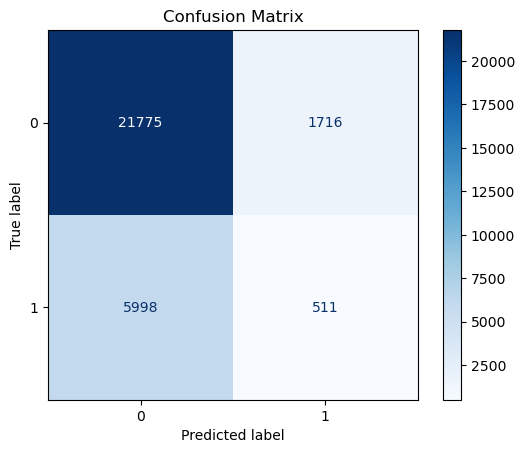

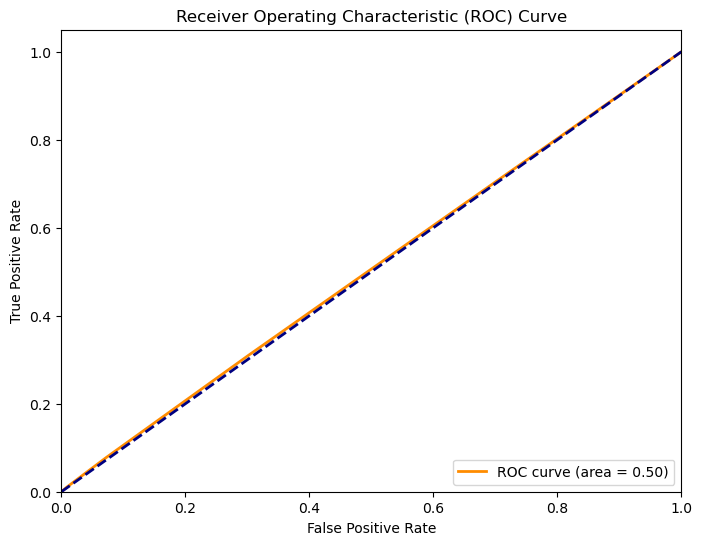

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

# Suppress specific FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning, module='scipy.stats')

# Encode categorical variables (if any)
for column in data.columns:
    if data[column].dtype == 'object':  # Check if the column is categorical
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

# Assuming the last column is the target and the rest are features
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can change the number of neighbors
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Cross-validation score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(knn_model, X, y, cv=cv, scoring='accuracy')
print(f"\nCross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")

# Plot Confusion Matrix using ConfusionMatrixDisplay
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_prob = knn_model.predict_proba(X_test)[:, 1]  # For binary classification, use the positive class probability
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Random Forest Classification and Evaluation


Confusion Matrix:
[[23491     0]
 [ 6507     2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     23491
           1       1.00      0.00      0.00      6509

    accuracy                           0.78     30000
   macro avg       0.89      0.50      0.44     30000
weighted avg       0.83      0.78      0.69     30000


Accuracy Score:
0.7831

Cross-validation scores: [0.7801  0.78015 0.78005 0.78005 0.77985]
Mean cross-validation score: 0.7800400000000001


<Figure size 800x600 with 0 Axes>

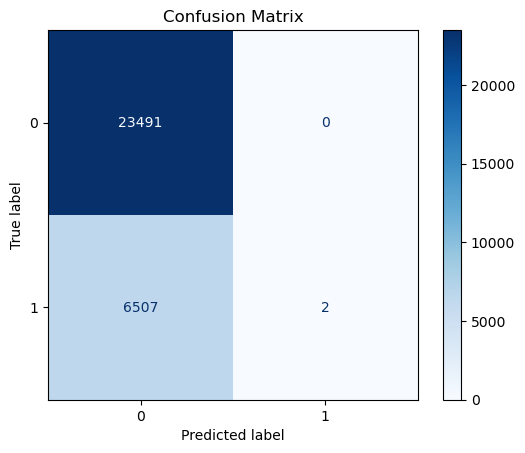

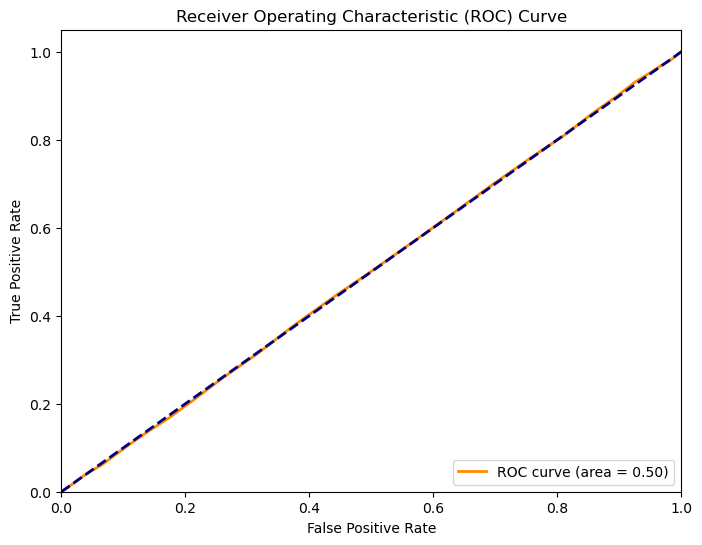

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

# Encode categorical variables (if any)
for column in data.columns:
    if data[column].dtype == 'object':  # Check if the column is categorical
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

# Assuming the last column is the target and the rest are features
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values (optional for Random Forest but good practice)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Cross-validation score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
print(f"\nCross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")

# Plot Confusion Matrix using ConfusionMatrixDisplay
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_prob = rf_model.predict_proba(X_test)[:, 1]  # For binary classification, use the positive class probability
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Logistic Regression Classification and Evaluation


Confusion Matrix:
[[23491     0]
 [ 6509     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     23491
           1       0.00      0.00      0.00      6509

    accuracy                           0.78     30000
   macro avg       0.39      0.50      0.44     30000
weighted avg       0.61      0.78      0.69     30000


Accuracy Score:
0.7830333333333334


/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Cross-validation scores: [0.7801  0.7801  0.78005 0.78005 0.78005]
Mean cross-validation score: 0.78007


<Figure size 800x600 with 0 Axes>

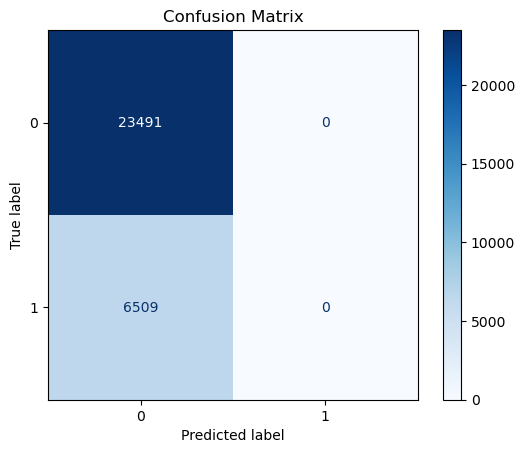

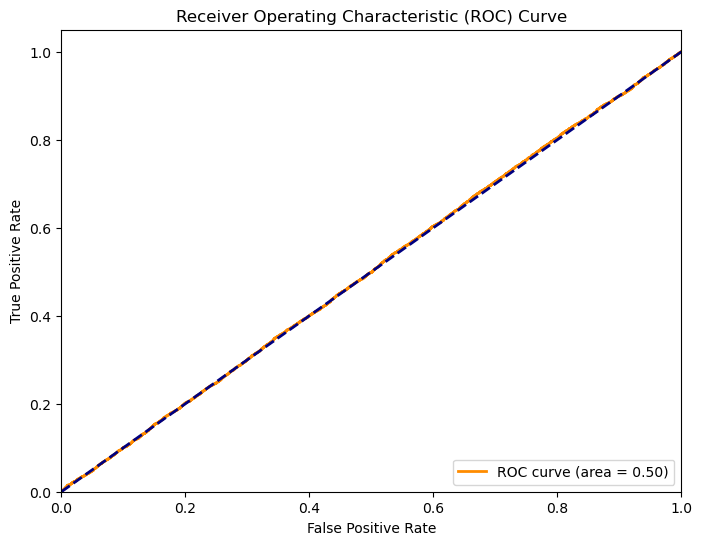

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning, module='scipy.stats')

# Encode categorical variables (if any)
for column in data.columns:
    if data[column].dtype == 'object':  # Check if the column is categorical
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

# Assuming the last column is the target and the rest are features
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=10000)
log_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Cross-validation score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(log_reg_model, X, y, cv=cv, scoring='accuracy')
print(f"\nCross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")

# Plot Confusion Matrix using ConfusionMatrixDisplay
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(log_reg_model, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_prob = log_reg_model.predict_proba(X_test)[:, 1]  # For binary classification, use the positive class probability
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Decision Tree Classification and Evaluation


Confusion Matrix:
[[17785  5706]
 [ 4989  1520]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     23491
           1       0.21      0.23      0.22      6509

    accuracy                           0.64     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.66      0.64      0.65     30000


Accuracy Score:
0.6435

Cross-validation scores: [0.64355 0.6438  0.644   0.6447  0.6485 ]
Mean cross-validation score: 0.6449100000000001


<Figure size 800x600 with 0 Axes>

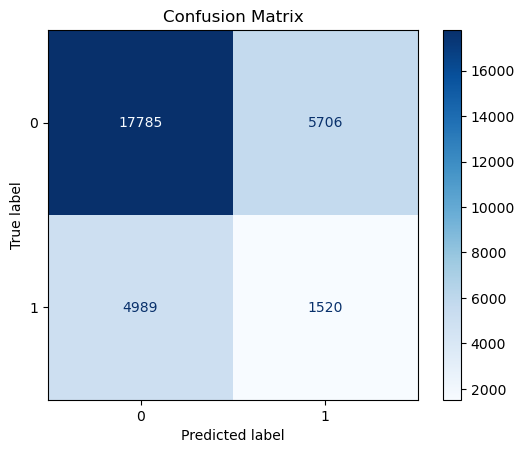

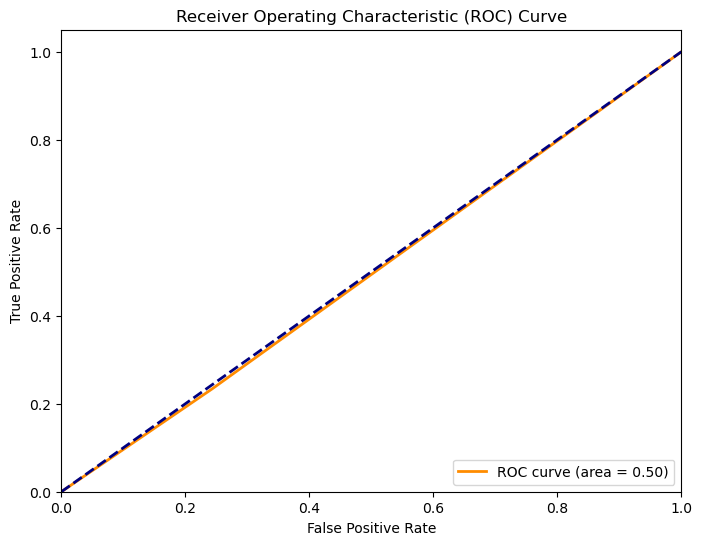

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning, module='scipy.stats')

# Encode categorical variables (if any)
for column in data.columns:
    if data[column].dtype == 'object':  # Check if the column is categorical
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

# Assuming the last column is the target and the rest are features
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values (optional for Decision Trees but kept for consistency)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Cross-validation score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(dt_model, X, y, cv=cv, scoring='accuracy')
print(f"\nCross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")

# Plot Confusion Matrix using ConfusionMatrixDisplay
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(dt_model, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_prob = dt_model.predict_proba(X_test)[:, 1]  # For binary classification, use the positive class probability
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## XG Boost Classification and Evaluation

/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Confusion Matrix:
[[23349   142]
 [ 6479    30]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.88     23491
           1       0.17      0.00      0.01      6509

    accuracy                           0.78     30000
   macro avg       0.48      0.50      0.44     30000
weighted avg       0.65      0.78      0.69     30000


Accuracy Score:
0.7793


/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn


Cross-validation scores: [0.77735 0.7779  0.77765 0.7778  0.77815]
Mean cross-validation score: 0.7777700000000001


<Figure size 800x600 with 0 Axes>

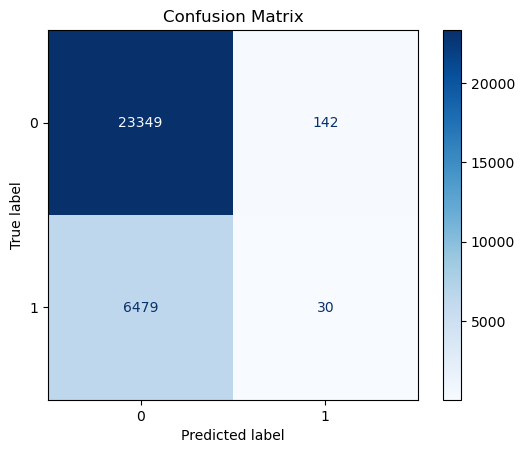

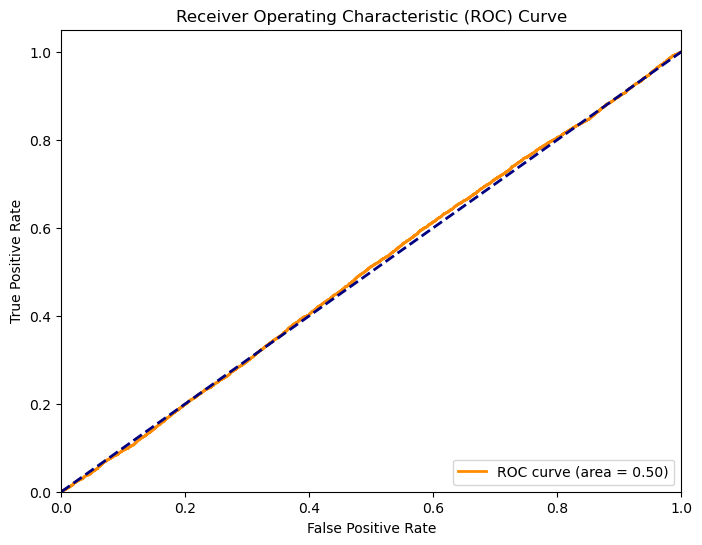

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning, module='scipy.stats')

# Encode categorical variables (if any)
for column in data.columns:
    if data[column].dtype == 'object':  # Check if the column is categorical
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

# Assuming the last column is the target and the rest are features
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values (optional but generally recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Cross-validation score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='accuracy')
print(f"\nCross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")

# Plot Confusion Matrix using ConfusionMatrixDisplay
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # For binary classification, use the positive class probability
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## LDA Classification and Evaluation


Confusion Matrix:
[[23491     0]
 [ 6509     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     23491
           1       0.00      0.00      0.00      6509

    accuracy                           0.78     30000
   macro avg       0.39      0.50      0.44     30000
weighted avg       0.61      0.78      0.69     30000


Accuracy Score:
0.7830333333333334


/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akifsaeed/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Cross-validation scores: [0.7801  0.7801  0.78005 0.78005 0.78005]
Mean cross-validation score: 0.78007


<Figure size 800x600 with 0 Axes>

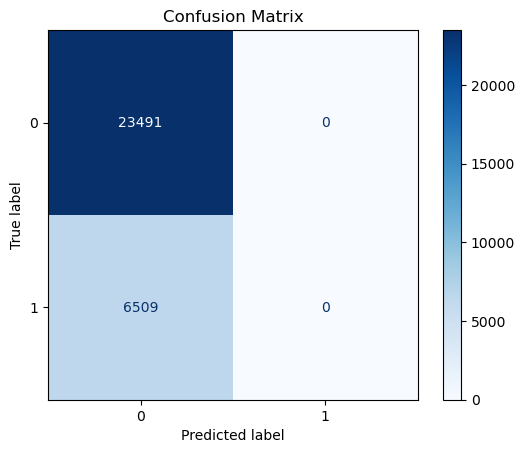

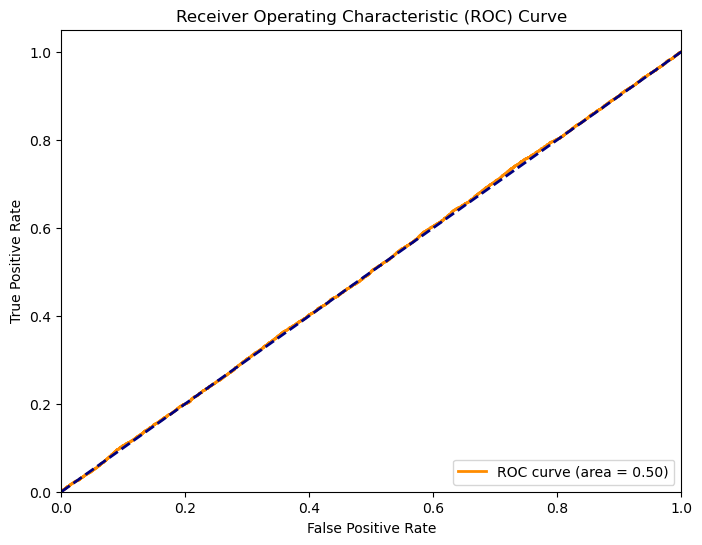

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning, module='scipy.stats')

# Encode categorical variables (if any)
for column in data.columns:
    if data[column].dtype == 'object':  # Check if the column is categorical
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

# Assuming the last column is the target and the rest are features
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the LDA model
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lda_model.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Cross-validation score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(lda_model, X, y, cv=cv, scoring='accuracy')
print(f"\nCross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {cross_val_scores.mean()}")

# Plot Confusion Matrix using ConfusionMatrixDisplay
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(lda_model, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
y_prob = lda_model.predict_proba(X_test)[:, 1]  # For binary classification, use the positive class probability
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Cross Validation Performance Visualization of 6 Predictive Models

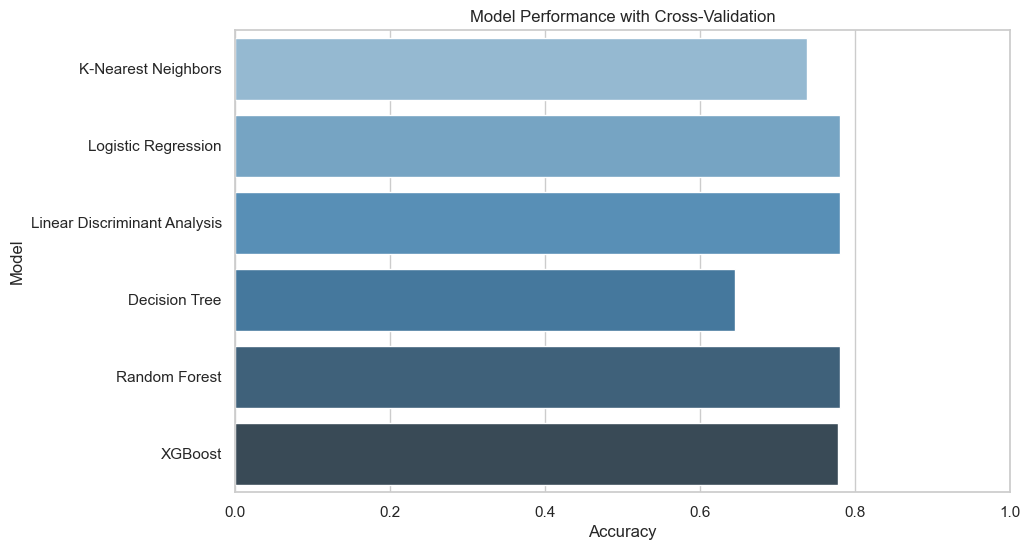

In [79]:
data = pd.read_csv('Desktop/ML/lung_cancer_mortality_data_sampled.csv')

# Encode categorical variables (if any)
for column in data.columns:
    if data[column].dtype == 'object':  # Check if the column is categorical
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

# Assuming the last column is the target and the rest are features
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Standardize the feature values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize models
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_names = []
cv_scores = []

# Perform cross-validation for each model
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    model_names.append(name)
    cv_scores.append(scores.mean())

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Cross-Validation Accuracy': cv_scores
})

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cross-Validation Accuracy', y='Model', data=results_df, palette='Blues_d')
plt.title('Model Performance with Cross-Validation')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.show()